Consider a specific SDE
$$\mathrm{d}X_t^{t_0}=-10\pi\mathrm{d}X_t^{t_0}+\sin{(2\pi t)}\mathrm{d}t+\sigma\mathrm{d}W_t $$

The true solution is $$X_t^*=\int_{-\infty}^t e^{-10\pi(t-s)}\sin(2\pi t)\mathrm{d}t+\sigma\int_{-\infty}^te^{-10\pi(t-s)}\mathrm{d}W_s$$

We shall find a large $N$ such that we evaluate $\int_{-\infty}^te^{-10\pi(t-s)}\mathrm{d}W_s$ by $\int_{-N}^te^{-10\pi(t-s)}\mathrm{d}W_s$

In the numerical example, we set $t=0$, $N=16$, $dt=2^{-NN}$, $NN\in\{4,5,6,7,8,9,10\}$ 

Besides, we should be familar with the notation that $a=10\pi$ and $b=2\pi$ and $\sigma=0.05$.

In [43]:
import numpy as np
import random
import time
from matplotlib.pylab import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pylab import *
from scipy import optimize
np.random.seed(1109)

In [106]:
def BMBase(T,M,h):
    """
    Generating 1-dimensional BM with M realizations and N increments upto time T (finest level)
    """
    N=int(float(T)/h) #stepsize#
    dw = np.sqrt(h)*np.random.randn(M,N) 
    W = np.insert(np.cumsum(dw,axis=1),0,0,axis=1)
    return W[:,::-1]

In [206]:
def derivedBM(T,h,W,IntNum):
    """
    The Brownian motion generated by using the finest level BM
    """
    M=len(W)
    Dt=IntNum*h #Stepsize based on higher level NN#
    IncNum=int(float(T)/Dt) #Increment Number 

    BM=np.zeros((M,IncNum+1)) #BB needed for the higher level NN
    t_gridcorse=np.zeros((M,IncNum+1)) #time frame based on BB and BM of level NN
    for i in range(IncNum+1):
        BM[:,i] = W[:,i*IntNum] #The BM is derived from the finest level#
        t_gridcorse[:,i]=Dt*i
    return BM, -t_gridcorse[:,::-1]

In [168]:
def f(x, t,a=10*np.pi,b=2*np.pi):
    """
    drift term for Eqn. final
    """
    
    
    f_1=-a*x+np.sin(b*t)
    return f_1

def g(dW,sigma=0.05):
    """
    difussion term for Eqn. final
    """
    g=sigma*dW
    return g


In [169]:
def BackwardEuler(y_ini,h,t_ini, f,g1):
    """
    BackwardEuler scheme implemented for Eqn
    """
    
     ####### solve implicit euler equtian for next time step with newton method
    def implicit_(y,y_ini_,t_ini_,g1_):
        return y - y_ini_ -f(y,t_ini_+h)*h -g1_
    
    output=np.array([optimize.newton(implicit_,y_ini[j],args=(y_ini[j],t_ini[j],g1[j],)) for j in range(len(t_ini))])

    return output

def Euler(x_ini,h,f1,g1):
    """
    Euler scheme implemented for Eqn
    """
    return x_ini+f1*h+g1

In [214]:
def path_class(x0,Dt,W,t_grid):
    """
    path simulated up to time T based on level NNN
    """
    M,N=W.shape[0],W.shape[1]
    
    #Initiating paths via classical Milstein
    X1,X2=np.zeros((M,N)),np.zeros((M,N))
    X1[:,0],X2[:,0] =x0,x0 
 
    for i in range(N)[1:]:
        #1-dim increments for BM of level NN (without considering BB)
        dW1=(W[:,i]-W[:,i-1]).reshape(1,-1)[0] 
        #Evaluating coefficient functions


        t_pre=t_grid[:,i-1]
        t_now=t_grid[:,i]
        X_now=X1[:,i-1].reshape(1,-1)[0]

        f1 =f(X_now, t_pre)
        
        g1 =g(dW1)

        #Evaluating the path values for the next step
        X1[:,i]=Euler(X_now,Dt,f1,g1)         
        
        X2[:,i]=BackwardEuler(X_now,Dt,t_now, f,g1)
    return X1[:,-1],X2[:,-1]

In [292]:
def true_sol(Dt,M,W,t_grid,a,b,sigma):
    
    dt_part=(-np.cos(b*t_grid[:,-1])+a*np.sin(b*t_grid[:,-1])/b)*b/(b**2-a**2)
    
    #dW_part=np.exp(-a*t_grid[:,-1])*np.sum([(W[:,i+1]-W[:,i])*(np.exp(a*t_grid[:,i])+np.exp(a*t_grid[:,i+1]))/2 for i in range(W.shape[1])[:-1]],axis=0)
    
    dW_part=W[:,-1]-a*np.exp(-a*t_grid[:,-1])*Dt*np.sum([W[:,i]*np.exp(a*t_grid[:,i]) for i in range(W.shape[1])[:-1]],axis=0)
    return dt_part+sigma*dW_part
    

In [289]:
def initial_sol(a,b,t_grid):
    
    return np.exp(a*t_grid[0,0])*(-np.cos(b*t_grid[:,0])+a*np.sin(b*t_grid[0,0])/b)/(1-a**2/b**2)/b

In [150]:
def errorL2(X,Xtrueapprox):
    """
    The L2 error evaluated
    """
    error=np.sqrt(np.mean(np.power(X-Xtrueapprox,2)))
    return error

In [300]:
def final_performance(x0,T,h,Bbase,IntNum_list,true_sols=None):
    
    e_list=[]
    be_list=[]
    
    if true_sols is None:
        _,tbase_grid=derivedBM(T,h,Bbase,1)
        _,true_sols=path_class(x0,h,Bbase,tbase_grid)
    
    for IntNum in IntNum_list:
        
        BM,t_grid=derivedBM(T,h,Bbase,IntNum)
        Dt=h*IntNum
        Xe,Xbe=path_class(x0,Dt,BM,t_grid)

        e_list.append(errorL2(true_sols,Xe))
        be_list.append(errorL2(true_sols,Xbe))
        
        
    return np.array(e_list),np.array(be_list)
        

In [302]:
T=8
M=500
h=2**(-15)
Bbase=BMBase(T,M,h)
a,b,alpha=10*np.pi,2*np.pi,0.05

In [303]:
_,tbase_grid=derivedBM(T,h,Bbase,1)

true_sols=true_sol(h,M,Bbase,tbase_grid,a,b,alpha)

In [295]:
true_sols

array([0.01445031, 0.00340811, 0.01151289, 0.00801647, 0.00922448])

In [296]:
x0=initial_sol(a,b,tbase_grid)

In [301]:
final_performance(x0[0],T,h,Bbase,[2**7,2**8,2**9,2**10,2**11],true_sols=None)

[ 0.0021205  -0.00927025 -0.00100538 -0.00482784 -0.00365514]
[ 1.91548111e-03 -9.21415074e-03 -1.27691950e-05 -5.07690506e-03
 -4.57603456e-03]
[ 0.0036425  -0.01120496  0.00086169 -0.00485861 -0.00476625]
[ 0.00679799 -0.01257221  0.00457132 -0.00399402 -0.00691466]
[ 0.07994375  0.00159614 -0.04759614 -0.05924133  0.00706479]


(array([0.00022773, 0.00074453, 0.00162286, 0.00405263, 0.04790398]),
 array([0.00039093, 0.00095332, 0.00178311, 0.00487405, 0.01880474]))

In [341]:
L2errorC=np.array([0.00039898, 0.00083824, 0.00181273, 0.00439497, 0.04627605])[::-1]
L2errorR=np.array([0.00035197, 0.00072647, 0.00166002,  0.00410766, 0.01194167])[::-1]

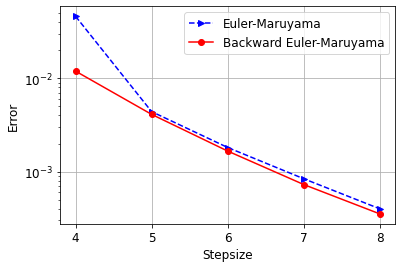

In [342]:
x=np.array([ 7,  8,  9,  10,  11],dtype='int')

yR=np.log2(L2errorR)
yC=np.log2(L2errorC)

mR,bR=polyfit(x,yR,1)
mC,bC=polyfit(x,yC,1)



# plt.plot(x,2**(mC*x+bC),'b>--',label='Euler-Maruyama')
# plt.yscale('log')

# plt.plot(x,2**(mR*x+bR),'ro-',label='Backward Euler-Maruyama')

plt.plot(x,L2errorC,'b>--',label='Euler-Maruyama')
plt.yscale('log')

plt.plot(x,L2errorR,'ro-',label='Backward Euler-Maruyama')
plt.yscale('log')
plt.ylabel('Error',fontsize=12)
plt.xlabel('Stepsize',fontsize=12)
# plt.text(9.5, 2**(-8.2), r'Order=%.2f' %-mC,color='blue')
# plt.text(8.5, 2**(-9.7), r'Order=%.2f'% -mR,color='red')
plt.xticks(x,[str(4),str(5),str(6),str(7),str(8)],fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':12})
plt.grid(True)
plt.savefig("./plots/" + "error_plot.jpeg", dpi=350)